In [17]:
# Libraries
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [19]:
# Loading data
# Chikkaballapur: 13°25'43.0"N 77°44'02.9"E
# Raichur: xxx N, xxx E, tba

# Setting directory
# My script is in my working directory already, but adjust if needed
os.chdir("C:/Users/48512/Desktop/Climate Studies/Period 5 and 6/Design of climate change mitigation and adaptation strategies/Data")

t_max_chik = pd.read_csv('dataimd/tmax_13.25_77.44.csv', delimiter=",")
t_max_raich = pd.read_csv('dataimd/tmax_16.50_76.75.csv', delimiter=",")

In [21]:
# Cleaning up the data. Setting a date time index, that is in the correct date time format (originally the format is object)
# It makes it easier to slice the data to for example yearly and monthly values

# For Chikkaballapur
t_max_chik["date_time"] = pd.to_datetime(t_max_chik["DateTime"])

# Set date_time as the index
t_max_chik.set_index("date_time", inplace=True)

del t_max_chik['DateTime']

# For Raichur
t_max_raich["date_time"] = pd.to_datetime(t_max_raich["DateTime"])

# Set date_time as the index
t_max_raich.set_index("date_time", inplace=True)

del t_max_raich['DateTime']

In [7]:
# To analyse consecutive hot days hot day needs to be described and then flagged

In [23]:
# Defining a function for setting a treshold for a hot day
def get_percentile(df, years, percentile, column_index=0): 
    
    # Get the start and end date
    start_date = df.index.min()
    end_date = start_date + pd.DateOffset(years=years)
    
    # Filter the data
    df_subset = df.loc[start_date:end_date]
    
    # Select the column by index
    data_column = df_subset.iloc[:, column_index]
    
    # Calculate the percentile
    threshold = data_column.quantile(percentile)
    
    print(f"{int(percentile*100)}th percentile over first {years} years ({start_date.date()} to {end_date.date()}): {threshold:.2f}")
    return threshold


In [25]:
# Treshold settings
first_years = 20 # how many first years to set the treshold,
percentile_value = 0.965 # what percentile, if top 10% of highest values then 0.9 and so on

In [27]:
# (dataframe, how many first years to set the treshold, what percentile, if top 10% of highest values then 0.9 and so on)
treshold_raich = get_percentile(t_max_raich, first_years, percentile_value)

96th percentile over first 20 years (1951-01-01 to 1971-01-01): 40.01


In [29]:
treshold_chik = get_percentile(t_max_chik, first_years, percentile_value)

96th percentile over first 20 years (1951-01-01 to 1971-01-01): 35.21


In [31]:
# Now hot days in the dataframe will be flagged
# This will create a collumn with true/false values. True if the temperature is equal/above set treshold
hot_raich = t_max_raich.iloc[:, 0] >= treshold_raich
hot_chik = t_max_chik.iloc[:, 0] >= treshold_chik


In [33]:
pd.set_option('display.max_rows', None)
hot_raich

date_time
1951-01-01    False
1951-01-02    False
1951-01-03    False
1951-01-04    False
1951-01-05    False
1951-01-06    False
1951-01-07    False
1951-01-08    False
1951-01-09    False
1951-01-10    False
1951-01-11    False
1951-01-12    False
1951-01-13    False
1951-01-14    False
1951-01-15    False
1951-01-16    False
1951-01-17    False
1951-01-18    False
1951-01-19    False
1951-01-20    False
1951-01-21    False
1951-01-22    False
1951-01-23    False
1951-01-24    False
1951-01-25    False
1951-01-26    False
1951-01-27    False
1951-01-28    False
1951-01-29    False
1951-01-30    False
1951-01-31    False
1951-02-01    False
1951-02-02    False
1951-02-03    False
1951-02-04    False
1951-02-05    False
1951-02-06    False
1951-02-07    False
1951-02-08    False
1951-02-09    False
1951-02-10    False
1951-02-11    False
1951-02-12    False
1951-02-13    False
1951-02-14    False
1951-02-15    False
1951-02-16    False
1951-02-17    False
1951-02-18    False
1951-02-19

In [35]:
def analyze_hot_streaks(df, threshold, column_index=0):
    # Step 1: Identify hot days
    hot = df.iloc[:, column_index] > threshold

    # Step 2: Find streaks
    # Turning true/false to 1/0
    hot_int = hot.astype(int)
    
    streak_id = (hot_int != hot_int.shift()).cumsum()

    # Step 3: Combine into DataFrame
    hot_streaks = pd.DataFrame({
        'is_hot': hot,
        'streak_id': streak_id
    })

    # Step 4: Filter only hot streaks
    only_hot_streaks = hot_streaks[hot_streaks['is_hot']]

    # Step 5: Group and summarize
    streak_info = only_hot_streaks.groupby('streak_id').apply(
        lambda group: pd.Series({
            'size': len(group),
          #  'mean_length': group.index.mean(), #
            'start_date': group.index.min(),
            'end_date': group.index.max()
        })
    ).reset_index(drop=True)

    # Step 6: Add year for analysis
    streak_info['year'] = streak_info['start_date'].dt.year

    # Step 6.1: Taking only streaks of 2 days and longer
    streak_info = streak_info[streak_info['size'] >= 2]

    # Step 7: Aggregate
    longest_per_year = streak_info.groupby('year')['size'].max()
    streaks_per_year = streak_info.groupby('year').size()
    #mean_streak_length = streak_info.groupby('year').mean()

    return streak_info, longest_per_year, streaks_per_year#, mean_streak_length


In [37]:
# Raichur
analyze_hot_streaks(t_max_raich, treshold_raich)
analyze_hot_streaks

C:\Users\48512\AppData\Local\Temp\ipykernel_7244\3547090072.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  streak_info = only_hot_streaks.groupby('streak_id').apply(


<function __main__.analyze_hot_streaks(df, threshold, column_index=0)>

In [39]:
# Chikaballapur
analyze_hot_streaks(t_max_chik, treshold_chik)

C:\Users\48512\AppData\Local\Temp\ipykernel_7244\3547090072.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  streak_info = only_hot_streaks.groupby('streak_id').apply(


(     size start_date   end_date  year
 1       3 1952-04-23 1952-04-25  1952
 2       6 1952-04-29 1952-05-04  1952
 5       3 1952-05-10 1952-05-12  1952
 6       3 1952-05-17 1952-05-19  1952
 8       3 1953-04-30 1953-05-02  1953
 10      3 1954-04-19 1954-04-21  1954
 11      3 1955-04-01 1955-04-03  1955
 12      2 1955-04-15 1955-04-16  1955
 14     11 1956-04-18 1956-04-28  1956
 17      4 1957-05-01 1957-05-04  1957
 18      6 1957-05-07 1957-05-12  1957
 20      3 1958-04-07 1958-04-09  1958
 22      2 1958-04-24 1958-04-25  1958
 24      2 1959-03-25 1959-03-26  1959
 27      3 1959-04-12 1959-04-14  1959
 28      2 1959-04-26 1959-04-27  1959
 29      2 1959-04-30 1959-05-01  1959
 39      9 1961-03-20 1961-03-28  1961
 40     13 1961-04-13 1961-04-25  1961
 41      2 1961-05-13 1961-05-14  1961
 43      2 1962-05-01 1962-05-02  1962
 44      2 1962-05-04 1962-05-05  1962
 49      2 1964-03-31 1964-04-01  1964
 52      4 1964-04-13 1964-04-16  1964
 53     14 1964-04-18 196

In [45]:
# Function to plot the number of hot streaks and the maximum lenght of a streak in a year
def plot_hot_streak_summary(df, threshold, column_index=0, location="Unknown"):

    # Step 1: Identify hot days
    hot = df.iloc[:, column_index] > threshold

    # Step 2: Streak grouping
    hot_int = hot.astype(int)
    streak_id = (hot_int != hot_int.shift()).cumsum()

    hot_streaks = pd.DataFrame({
        'is_hot': hot,
        'streak_id': streak_id
    })
    only_hot_streaks = hot_streaks[hot_streaks['is_hot']]

    # Step 3: Summarize each hot streak
    streak_info = only_hot_streaks.groupby('streak_id').apply(
        lambda group: pd.Series({
            'size': len(group),
            'start_date': group.index.min(),
            'end_date': group.index.max()
        })
    ).reset_index(drop=True)

    streak_info['year'] = streak_info['start_date'].dt.year
    # Only keep streaks of 2 days or more
    streak_info = streak_info[streak_info['size'] >= 6]

    # Step 4: Aggregate per year
    longest_per_year = streak_info.groupby('year')['size'].max()
    streaks_per_year = streak_info.groupby('year').size()

    # Step 5: Plotting
    years = longest_per_year.index

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    # Longest streak
    axs[0].plot(years, longest_per_year.values, marker='o', color='crimson')
    axs[0].set_title(f"Longest Streak >{threshold:.0f}°C in {location}")
    axs[0].set_ylabel("Days")
    axs[0].set_xlabel("Year")
    axs[0].grid(True)

    # Streak count
    axs[1].bar(streaks_per_year.index, streaks_per_year.values, color='steelblue')
    axs[1].set_title(f"Number of Hot Streaks >{threshold:.0f}°C in {location}")
    axs[1].set_ylabel("Number of Streaks")
    axs[1].set_xlabel("Year")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


C:\Users\48512\AppData\Local\Temp\ipykernel_7244\2994973475.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  streak_info = only_hot_streaks.groupby('streak_id').apply(


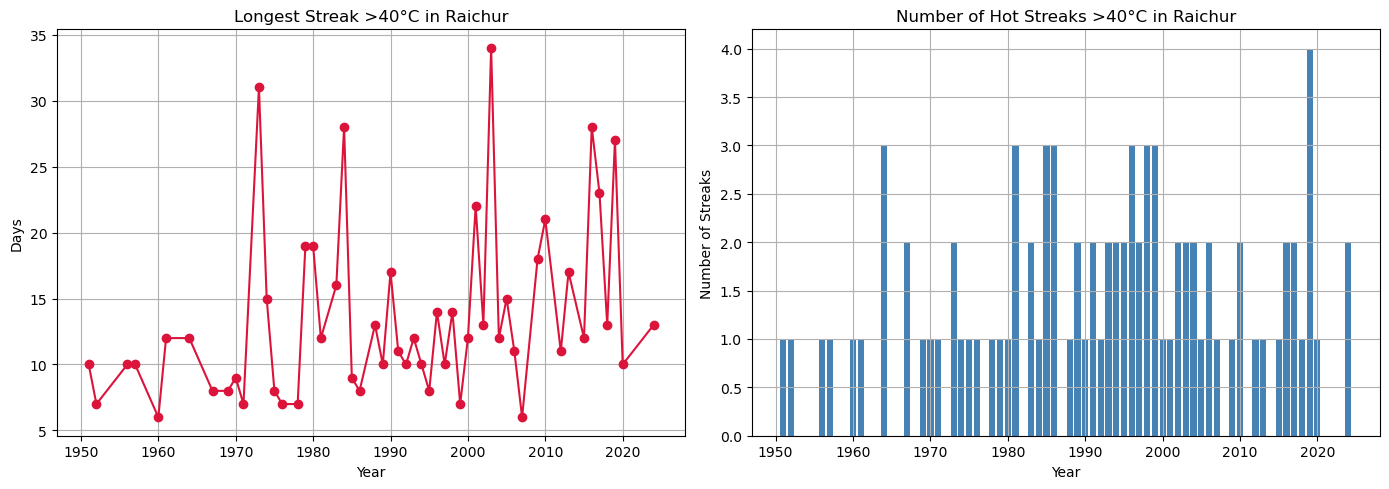

In [47]:
# Plotting for Raichur
plot_hot_streak_summary(t_max_raich, treshold_raich, location= "Raichur")

C:\Users\48512\AppData\Local\Temp\ipykernel_7244\2994973475.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  streak_info = only_hot_streaks.groupby('streak_id').apply(


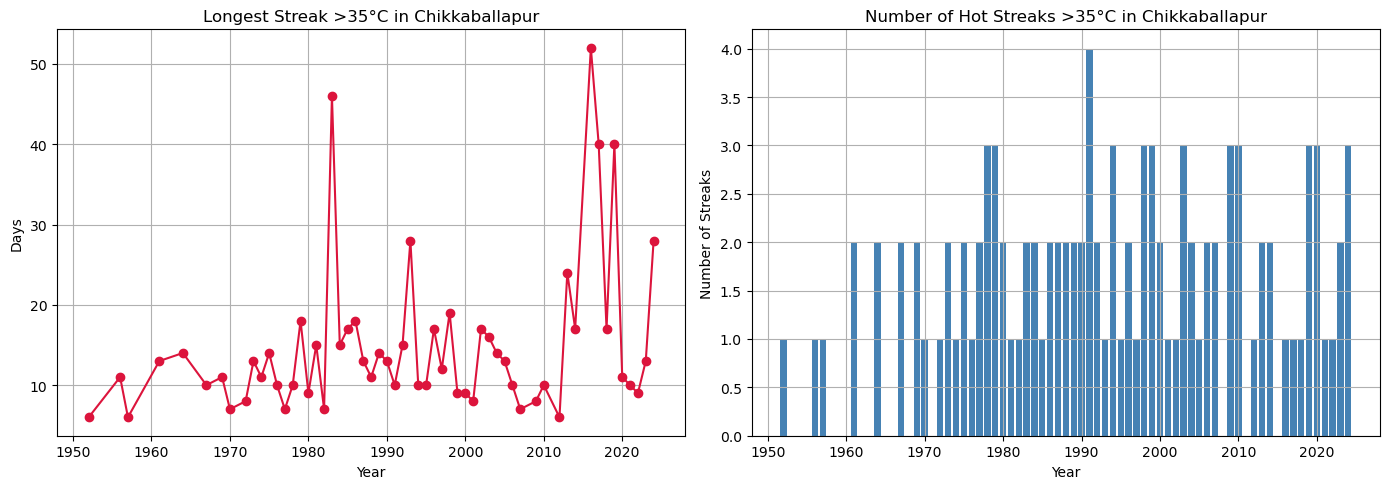

In [49]:
# PLotting for Chikkballapur
plot_hot_streak_summary(t_max_chik, treshold_chik, location= "Chikkaballapur")